In [3]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import datetime as dt
import time
from datetime import date, timedelta
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from scipy.stats import poisson
import scipy.stats as stats
%matplotlib inline

from google.oauth2.service_account import Credentials
import google_auth_httplib2
import pygsheets
import df2gspread as d2g
import googleapiclient
from googleapiclient  import discovery
from httplib2 import Http
from oauth2client import file, client, tools
from gspread_formatting.dataframe import format_with_dataframe, BasicFormatter
from gspread_formatting import Color
import logging

from oauth2client.service_account import ServiceAccountCredentials
from google.oauth2 import service_account
import gslides
from gslides import (Frame,Presentation,Spreadsheet,Table,Series,Chart)

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import sqlalchemy as db
from sqlalchemy import create_engine
import mysql.connector
import psycopg2
from prophet import Prophet

In [4]:
data = pd.read_csv('C:/Users/leemn/Downloads/transactions.csv')

In [5]:
data.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [6]:
data.shape

(83488, 3)

In [7]:
data['store_nbr'].nunique()

54

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [10]:
data['date'] = pd.to_datetime(data['date'])

In [11]:
print("The data has sales from {} to {}".format(min(data['date']),
                                                 max(data['date'])))

The data has sales from 2013-01-01 00:00:00 to 2017-08-15 00:00:00


In [12]:
data.drop('store_nbr', axis=1, inplace=True)

In [13]:
data.head()

,date,transactions
0,2013-01-01,770
1,2013-01-02,2111
2,2013-01-02,2358
3,2013-01-02,3487
4,2013-01-02,1922


In [15]:
p = Prophet(interval_width=0.92, daily_seasonality=True)

2022-07-16 21:54:07,837 : DEBUG : cmd: where.exe tbb.dll
cwd: None
2022-07-16 21:54:07,910 : DEBUG : TBB already found in load path


We use the interval_width argument to estimate the uncertainty interval from the number of samples used. We’ve set ours to 0.92.

The argument daily_seasonality=True will fit daily seasonality for a sub-daily time series. It will default to weekly and yearly seasonalities if you don’t set this parameter.

In [18]:
# need to rename the date column to ds and transactions columns to y.
data.columns = ['ds', 'y']
data.head()

,ds,y
0,2013-01-01,770
1,2013-01-02,2111
2,2013-01-02,2358
3,2013-01-02,3487
4,2013-01-02,1922


In [19]:
# train model
model = p.fit(data)

2022-07-16 22:01:41,090 : DEBUG : input tempfile: C:\Users\leemn\AppData\Local\Temp\tmpfopz_ayu\294xg72h.json
2022-07-16 22:01:42,697 : DEBUG : input tempfile: C:\Users\leemn\AppData\Local\Temp\tmpfopz_ayu\c3o2m0xl.json
2022-07-16 22:01:42,708 : DEBUG : idx 0
2022-07-16 22:01:42,708 : DEBUG : running CmdStan, num_threads: None
2022-07-16 22:01:42,709 : DEBUG : CmdStan args: ['C:\\Users\\leemn\\AppData\\Roaming\\Python\\Python39\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=4482', 'data', 'file=C:\\Users\\leemn\\AppData\\Local\\Temp\\tmpfopz_ayu\\294xg72h.json', 'init=C:\\Users\\leemn\\AppData\\Local\\Temp\\tmpfopz_ayu\\c3o2m0xl.json', 'output', 'file=C:\\Users\\leemn\\AppData\\Local\\Temp\\tmpw9xypob1\\prophet_model-20220716220142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:01:42 - cmdstanpy - INFO - Chain [1] start processing
2022-07-16 22:01:42,711 : INFO : Chain [1] start processing
22:01:50 - cmdstanpy - INFO - Chain [1] done processing
2

In [20]:
future = p.make_future_dataframe(periods=200, freq='D')
future.tail()

,ds
1877,2018-02-27
1878,2018-02-28
1879,2018-03-01
1880,2018-03-02
1881,2018-03-03


From the results, we can see that the model has made future predictions, 200 days away from the last data value using a daily frequency. If you want to train for longer periods, you can change the value in the periods=200 argument.

In [24]:
# make predictions
forecast_prediction = p.predict(future)
forecast_prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,953.636515,455.127736,3616.364065,953.636515,953.636515,1024.349953,1024.349953,1024.349953,734.632387,...,-95.380357,-95.380357,-95.380357,385.097923,385.097923,385.097923,0.0,0.0,0.0,1977.986468
1,2013-01-02,953.923516,338.674146,3536.640351,953.923516,953.923516,1005.889921,1005.889921,1005.889921,734.632387,...,-72.423855,-72.423855,-72.423855,343.681390,343.681390,343.681390,0.0,0.0,0.0,1959.813437
2,2013-01-03,954.210516,131.573403,3350.903744,954.210516,954.210516,891.671483,891.671483,891.671483,734.632387,...,-143.603858,-143.603858,-143.603858,300.642955,300.642955,300.642955,0.0,0.0,0.0,1845.881999
3,2013-01-04,954.497517,145.128291,3492.819526,954.497517,954.497517,951.855414,951.855414,951.855414,734.632387,...,-39.457262,-39.457262,-39.457262,256.680288,256.680288,256.680288,0.0,0.0,0.0,1906.352930
4,2013-01-05,954.784517,525.178369,3884.769507,954.784517,954.784517,1202.992284,1202.992284,1202.992284,734.632387,...,255.867875,255.867875,255.867875,212.492022,212.492022,212.492022,0.0,0.0,0.0,2157.776801


From the results generated, the model has generated a lot of sales information in addition to the predicted ds and yhat column. The most important column is the yhat column, as it is what represents your sales forecast.

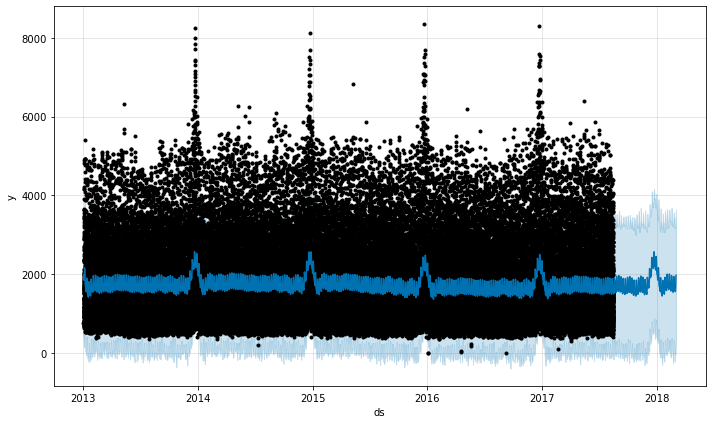

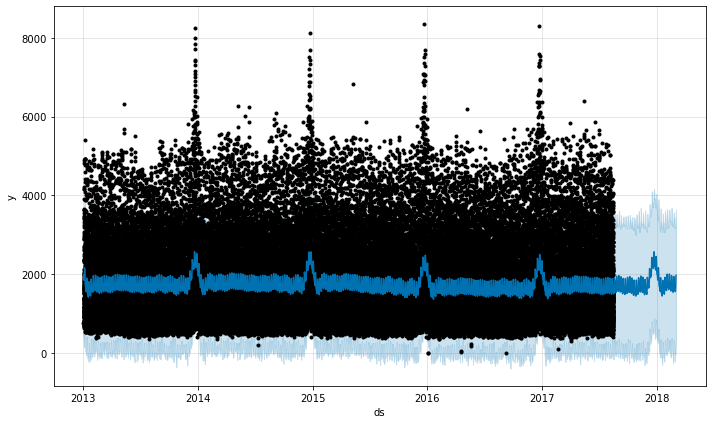

In [26]:
p.plot(forecast_prediction)

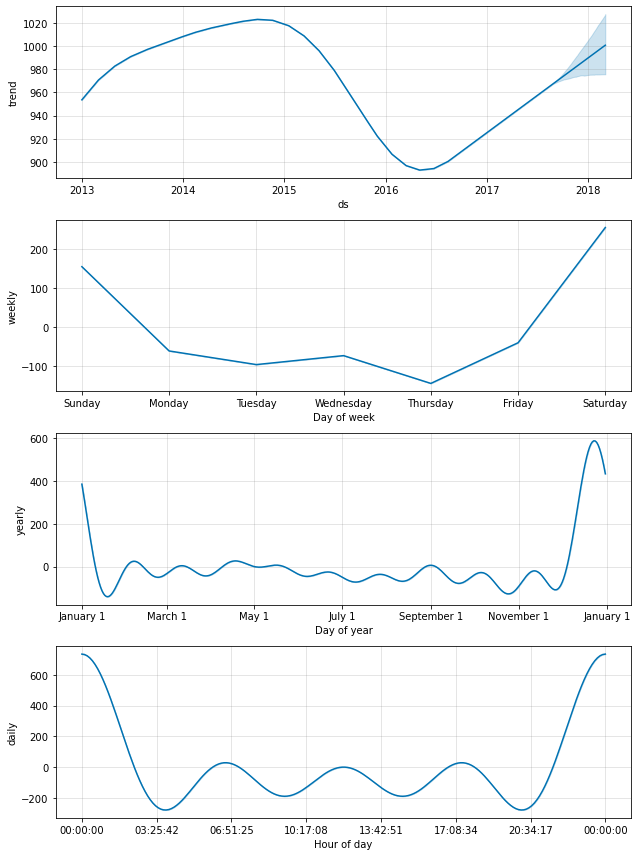

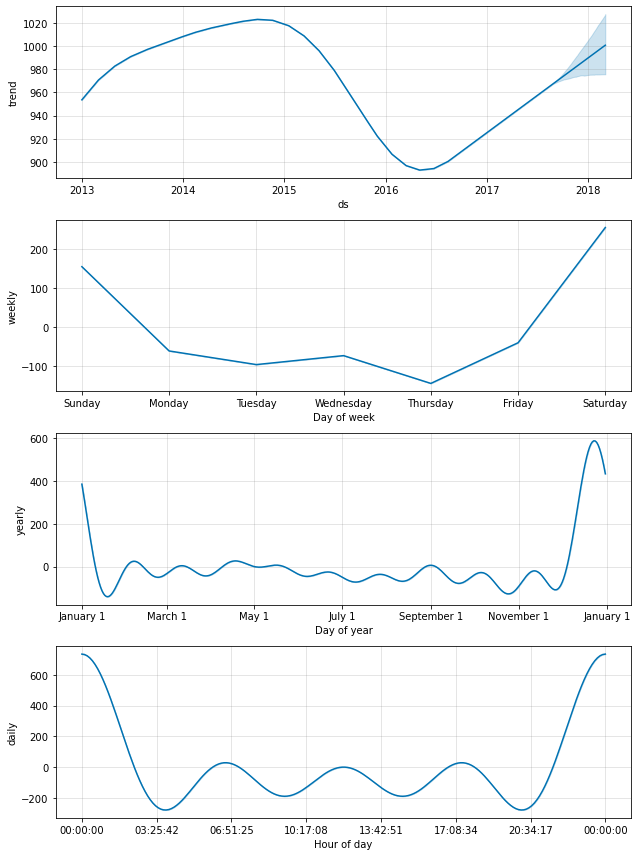

In [27]:
p.plot_components(forecast_prediction)

more sales are made between Friday and Monday. Also, they seem to make a lot of sales between November and February. During the rest of the year, sales are average.

In [25]:
forecast_prediction.to_csv('forecast_prediction.csv')